# Lab 02 (Traveling Salesman Problem)

Using Evolutionary Algorithm

In [15]:
import functools
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from geopy.distance import geodesic
from tqdm.auto import tqdm

## Initialization

In [16]:
class Individual:
    def __init__(self, genome=None, fitness_score=None):
        self.genome = genome
        self.fitness = fitness_score

    def __repr__(self):
        return f"Fitness: {self.fitness}, {self.genome}"


# Function to read coordinates from a CSV file
def read_coordinates_from_csv(file_path):
    dtype_dict = {'city': 'string', 'lat': 'float64', 'lon': 'float64'}
    df = pd.read_csv(file_path, header=None, names=['city', 'lat', 'lon'], dtype=dtype_dict, low_memory=False)
    coords = df[['lat', 'lon']].values
    return coords


# Function to compute the distance matrix in kilometers
def distance_matrix(coords):
    dmat = np.zeros((len(coords), len(coords)), dtype=np.float64)
    for i, (x1, y1) in enumerate(coords):
        for j, (x2, y2) in enumerate(coords):
            dmat[i][j] = geodesic((x1, y1), (x2, y2)).km
    return dmat

## Helper Functions

In [17]:
def counter(fn):
    """Simple decorator for counting number of calls"""

    @functools.wraps(fn)
    def helper(*args, **kargs):
        helper.calls += 1
        return fn(*args, **kargs)

    helper.calls = 0
    return helper


@counter
def cost(dmat, path):
    """Calculate total distance of the TSP path"""
    total_distance = 0
    for i in range(len(path) - 1):
        u, v = path[i], path[i + 1]
        total_distance += dmat[u][v]

    # Add starting point to close the loop
    u, v = path[-1], path[0]
    total_distance += dmat[u][v]

    return total_distance


def fitness(dmat, individual):
    """
    Returns the fitness of a individual (to be minimized).
    The solution is assumed to be valid.
    """
    return cost(dmat, individual.genome)

## Genetic Operators

In [18]:
def create_random_genome(length):
    genome = np.arange(length)
    np.random.shuffle(genome)
    return genome


def mutation_swap(p1):
    """Swap two cities"""
    new_genome = p1.genome.copy()
    idx1, idx2 = np.random.randint(0, len(new_genome), 2)
    new_genome[idx1], new_genome[idx2] = new_genome[idx2], new_genome[idx1]
    return Individual(new_genome)


def mutation_inv(p1):
    """Reverse the order between cut-off points"""
    new_genome = p1.genome.copy()
    idx1, idx2 = np.sort(np.random.randint(0, len(new_genome), 2))

    new_genome = np.concatenate((new_genome[:idx1], new_genome[idx1:idx2 + 1][::-1], new_genome[idx2 + 1:]))
    return Individual(new_genome)


def mutation_multi(p1, prob_multi=0.5, prob_inv=0.5):
    """Apply the mutations multiple times"""
    new_ind = mutation_inv(p1) if np.random.random() < prob_inv else mutation_swap(p1)
    while np.random.random() < prob_multi:
        new_ind = mutation_inv(p1) if np.random.random() < prob_inv else mutation_swap(p1)
    return new_ind


def xover_order(p1, p2):
    """Order crossover"""
    length = len(p1.genome)

    # Choose cut-off points
    idx1, idx2 = np.sort(np.random.randint(0, length, 2))

    # Create offspring by copying the p1 genome between the cuts
    offspring = np.full((length,), -1)
    offspring[idx1:idx2] = p1.genome[idx1:idx2]

    # Fill the rest with p2 without repeating
    current_position = idx2 % length
    for gene in p2.genome:
        if gene not in offspring:
            offspring[current_position] = gene
            current_position = (current_position + 1) % length

    return Individual(offspring)


def parent_selection(population, n=2):
    """Implement tournament selection"""
    selected_individuals = random.sample(population, n)
    return min(selected_individuals, key=lambda individual: individual.fitness)

## Evolutionary Algorithm

100%|██████████| 2000/2000 [05:48<00:00,  5.74it/s]


TSP Path: [ 89 112  12 135  88  53 128  42  63  38  24  30  72  45 111 149  73 100
  99  91 101  49  20 166  62  65 143 131 117  96 104  14  79  55  97 113
  15  86 109  40 139 124  11  90   1  58  57   0  54  17  31   3 144  23
  16 157  48  41 146 151   6  71 162 106  61  82  92  93 132  78  75 137
 142  36 105 159  74  33  44 161  39  83  19  80 114 136 102  56  13 129
 160  87 140  98 165  46  10  43 121 115 141 127 147  34 110 148  47 116
 107 133   4 123  67  21 154 158  51  32  52  26  68 150  27 126 163  69
  50  95  66  81 164  60 122  35 108  94  18  59 156 103 119   7 145  25
  70  77   2 118 138   9 134  85  29 120  37   8 155 153 152  84  64   5
  22  76 130  28 125]
Total Distance Travelled: 43476.054423307534
Cost calls: 1200201


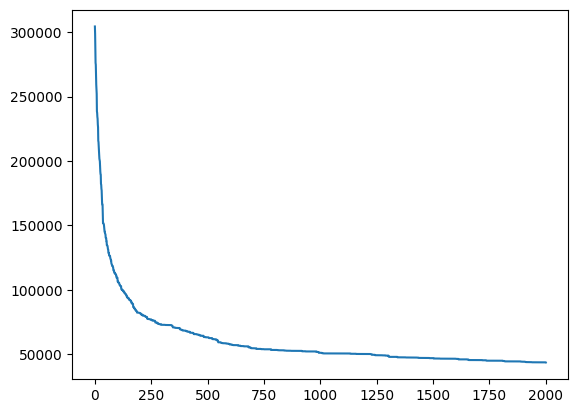

In [19]:
"""
Evolutionary algorithm:
    - Hyper-modern approach
    - Generational with elitism
"""

# Evolutionary algorithm Parameters
POPULATION_SIZE = 200
MAX_GENERATIONS = 2000
OFFSPRING_SIZE = POPULATION_SIZE * 3
PROB_MUTATION = 0.5
PROB_MULTI_MUT = 0.5
PROB_INV_MUT = 0.5
ELITISM = 1
plot_results = True
###################################

# Create problem
csv_file = 'cities/russia.csv'
coords = read_coordinates_from_csv(csv_file)
dmat = distance_matrix(coords)

# Initial population
population = [Individual(create_random_genome(len(coords))) for _ in range(POPULATION_SIZE)]
for p in population:
    p.fitness = fitness(dmat, p)

bests = []

population.sort(key=lambda ind: ind.fitness)
bests.append(population[0])

for _ in tqdm(range(MAX_GENERATIONS)):
    # Offspring generation
    offspring = []
    for _ in range(OFFSPRING_SIZE):
        if np.random.random() < PROB_MUTATION:
            p = parent_selection(population)
            o = mutation_multi(p, PROB_MULTI_MUT, PROB_INV_MUT)
        else:
            p1 = parent_selection(population)
            p2 = parent_selection(population)
            o = xover_order(p1, p2)
        offspring.append(o)

    for i in offspring:
        i.fitness = fitness(dmat, i)

    offspring.extend(population[:ELITISM])

    # Survivor selection
    population = offspring
    population.sort(key=lambda ind: ind.fitness)
    population = population[:POPULATION_SIZE]
    bests.append(population[0])

# Results
total_distance = cost(dmat, bests[-1].genome)
print(f"TSP Path: {bests[-1].genome}")
print(f"Total Distance Travelled: {total_distance}")
print(f"Cost calls: {cost.calls}")

if plot_results:
    # Plot fitness
    plt.plot(np.array([i.fitness for i in bests]))
    plt.show()